# LSTM

In [1]:
import numpy as np
import pandas as pd 
import re
import helper
import random
import string
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pdb

import time
import math

In [2]:
# Run this to reload helper.py so you don't have to restart the kernel
import importlib

importlib.reload(helper)

<module 'helper' from '/Users/glchau/Desktop/Caltech/CS155/loan-sharks/poems/helper.py'>

## Preprocess data

In [3]:
all_words, all_sequences, word_dict, all_sonnet_int = helper.getAllWordsAndSequences("data/shakespeare.txt", "data/Syllable_dictionary.txt")

## Variables and helper functions for RNN training 

In [4]:
all_character_sequences = [' '.join(seq[:-1]) for seq in all_sequences]
all_character_sequences_no_empty = [seq for seq in all_character_sequences if len(seq) > 0]


In [5]:
fixed_length_character_sequences_valid_start = [] 
big_string = ' '.join(all_character_sequences_no_empty)
big_string = ' ' + big_string
step_size = 5
for i in range(0, len(big_string)):
    if (big_string[i-1] == ' ') and (big_string[i] != ' '):
        if len(big_string[i:i+40]) == 40: 
            fixed_length_character_sequences_valid_start.append(big_string[i:i+40])        

In [6]:
len(fixed_length_character_sequences_valid_start)

17566

In [7]:
all_letters = string.ascii_lowercase + " '-"  # abcdefghijklmnopqrstuvwxyz '-
n_letters = len(all_letters) + 1 # Plus EOS marker
all_categories = [0] # Only have 1 category for now. We could try to categorize lines by position or ending rhyme
n_categories = len(all_categories)

lens = [len(seq) for seq in fixed_length_character_sequences_valid_start]
max_length = max(lens)
min_lenth = min(lens)
max_length

40

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
def inputTensor(line):
    # One-hot matrix of first to last letters (not including EOS) for input
    # tensor = torch.zeros(len(line), n_letters)
    # for li in range(len(line)):
    #     letter = line[li]
    #     tensor[li][all_letters.find(letter)] = 1
    
    # Indices 
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
    return torch.LongTensor(letter_indexes) #tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def inputTargetLists(line): 
    inputList = [all_letters.find(line[li]) for li in range(0, len(line))]
    targetList = [all_letters.find(line[li]) for li in range(1, len(line))]
    targetList.append(n_letters - 1)
    return inputList, targetList

In [10]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Generate a batch of lines with input and target tensors 
def randomBatch(category_lines, batch_size=16):
    input_tensors = []
    target_tensors = []
    for b in range(batch_size): 
        line = randomChoice(category_lines)
        inputList, targetList = inputTargetLists(line)
        
        input_tensors.append(inputList)
        target_tensors.append(targetList)
    return torch.LongTensor(input_tensors), torch.LongTensor(target_tensors)

### Training Functions

In [11]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
# train the RNN on the input and target batch values 

def train_batch(rnn, input_line_tensor, target_line_tensor, optimizer, criterion):
    
    # Put in extra dimension for the "Layer" dimension of LSTM inputs 
    input_line_tensor = torch.unsqueeze(input_line_tensor, dim=0)
    target_line_tensor = torch.unsqueeze(target_line_tensor, dim=0)
    
    # Initilize the hidden and cell matrices 
    hidden, cell = rnn.initHidden()

    # Zero out the gradients for each batch
    rnn.zero_grad()

    # Initlize loss to 0
    loss = 0

    # Iterate through all 40 characters in the sequence
    for i in range(input_line_tensor.size(2)):
        
        # Select only the ith character for the batch
        input_tensor = input_line_tensor[:, :, i] 
        target_tensor = target_line_tensor[:, :, i] 
        
        # Forward pass through RNN 
        output, (hidden, cell) = rnn(input_tensor, (hidden, cell))
        
        # Loss calculation
        l = criterion(torch.squeeze(output, dim=0), torch.squeeze(target_tensor, dim=0))
        loss += l.item() 

        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()

    return loss / rnn.batch_size

In [13]:
# Sample from a category and starting letter

def sample(rnn, start_letter='a', length=max_length, temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        rnn.eval()
        inputs = inputTensor(start_letter).to(device)
        hidden, cell = torch.zeros(1, 1, rnn.hidden_size).to(device), torch.zeros(1, 1, rnn.hidden_size).to(device)

        output_name = start_letter

        for i in range(length):
            inputs = inputs[None, :]
            
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)
            
            topi = torch.multinomial(output.data[0], 1)
            # pdb.set_trace()
            # topv, topi = output.topk(1)
            topi = topi[0][0]
            
            # Last index is <EOS> so we just kill the appending
            if topi == n_letters - 1:
                break 
            else:
                letter = all_letters[topi]
                output_name += letter
            
            inputs = inputTensor(letter).to(device)

        return output_name

In [14]:
# Sample from a category and starting letter

def sampleMultipleStart(rnn, start_seq='ant', length=max_length, temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        rnn.eval()
        
        
        hidden, cell = torch.zeros(1, 1, rnn.hidden_size).to(device), torch.zeros(1, 1, rnn.hidden_size).to(device)

        input_array = []
        for char in start_seq: 
            input_array.append(inputTensor(char).to(device))
        output_sequence = start_seq
        
        for i in range(len(start_seq) - 1): 
            inputs = input_array[i][None, :].to(device)
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)

        inputs = input_array[len(start_seq) - 1][None, :]
        for i in range(length):
            
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)
            # output = output.data[0] / sum(output.data[0][0]) 
            topi = torch.multinomial(output.data[0], 1)
            
            # topv, topi = output.topk(1)
            topi = topi[0][0]
            
            # Last index is <EOS> so we just kill the appending
            if topi == n_letters - 1:
                break 
            else:
                letter = all_letters[topi]
                output_sequence += letter
            
            inputs = inputTensor(letter)[None, :].to(device)

        return output_sequence

## One Hot encoding LSTM

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, batch_size, device, n_layers=1): # n_classes is output_size 
        super(RNN, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'
        

        # self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        # embeding = self.embedding(input_vals)
        one_hot = torch.nn.functional.one_hot(input_vals, num_classes=self.n_classes)
        # pdb.set_trace()
        output, hc = self.lstm(one_hot.float(), hc)
        output = self.decoder(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(self.device), torch.zeros(num_layers, batch_size, hidden_size).to(self.device)

In [16]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 256
n_iters = 15000
print_every = 500
plot_every = 500
learning_rate = 0.0005
############################## 

rnn = RNN(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(fixed_length_character_sequences_valid_start, batch_size=batch_size)
        loss = train_batch(rnn, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 5s (500 3%) 3.8773
2m 9s (1000 6%) 3.8244
3m 13s (1500 10%) 3.8316
4m 16s (2000 13%) 3.8275
5m 20s (2500 16%) 3.8084
6m 23s (3000 20%) 3.8150
7m 27s (3500 23%) 3.7547
8m 30s (4000 26%) 3.7767
9m 33s (4500 30%) 3.7528
10m 37s (5000 33%) 3.7539
11m 40s (5500 36%) 3.7679
12m 44s (6000 40%) 3.7235
13m 47s (6500 43%) 3.7552
14m 51s (7000 46%) 3.7511
15m 54s (7500 50%) 3.7514
16m 58s (8000 53%) 3.7571
18m 1s (8500 56%) 3.7092
19m 5s (9000 60%) 3.7318
20m 9s (9500 63%) 3.7266
21m 12s (10000 66%) 3.7419
22m 16s (10500 70%) 3.7102
23m 20s (11000 73%) 3.7427
24m 24s (11500 76%) 3.7430
25m 27s (12000 80%) 3.7469
26m 31s (12500 83%) 3.7269
27m 35s (13000 86%) 3.7187
28m 39s (13500 90%) 3.7206
29m 43s (14000 93%) 3.7067
30m 47s (14500 96%) 3.7366
31m 52s (15000 100%) 3.7079


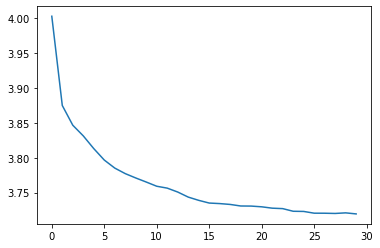

In [17]:
plt.plot(all_losses)

In [18]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=0.5)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

heart thou the world where the star
love the star that thou shall show
of the world where the world where the world
dear where the world where the world

heart thou the world where the
be the world where the world
just thou the star the world where the star
in the world where the world where the

heart thou the star that the world where
so thou the star what thou mare the world
dear where the world where the world where
in the world where the world where the world

for the world where the world where the
where the world where the star that


In [19]:
# Save model
torch.save(rnn.state_dict(), "./models/lstm_onehot_model_256hdim.pt")



In [28]:
start_sample = sampleMultipleStart(rnn, start_seq="shall i compare thee to a summer's day", 
                             length=1000, temperature=0.25)

start_sample


"shall i compare thee to a summer's day the world where the star what thou mare the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the world where the star dost thou the starth the starth the world where the world where

In [29]:
for line in range(14):
    print(' '.join(start_sample.split(" ")[line * 14:line * 14 + 10]))

shall i compare thee to a summer's day the world
thou mare the world where the world where the world
the world where the world where the world where the
where the world where the world where the world where
world where the world where the world where the world
the world where the world where the world where the
where the world where the world where the world where
world where the world where the world where the world
the world where the world where the world where the
where the world where the world where the world where
world where the world where the world where the world
the world where the world where the world where the
where the world where the world where the star dost
starth the world where the world where the star that


In [26]:
# Load model
# Model class must be defined somewhere
rnn_load_model = RNN(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size)
rnn_load_model.load_state_dict(torch.load("./models/lstm_onehot_model.pt"))
rnn_load_model.eval()

RuntimeError: Error(s) in loading state_dict for RNN:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([3200, 30]) from checkpoint, the shape in current model is torch.Size([1024, 30]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([3200, 800]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([3200]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([3200]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.weight: copying a param with shape torch.Size([30, 800]) from checkpoint, the shape in current model is torch.Size([30, 256]).

In [ ]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn_load_model, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=3.05)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

## Embedding LSTM

In [20]:
class RNN_Embedding(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, device, batch_size, n_layers=1): # n_classes is output_size 
        super(RNN_Embedding, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'

        self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        embeding = self.embedding(input_vals)
        # pdb.set_trace()
        output, hc = self.lstm(embeding, hc)
        output = self.decoder(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(device), torch.zeros(num_layers, batch_size, hidden_size).to(device)

In [21]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 256
n_iters = 15000
print_every = 500
plot_every = 500
learning_rate = 0.0005
############################## 

rnn_embedding = RNN_Embedding(input_size=n_letters, hidden_size=hidden_size, n_classes=n_letters, n_layers=1, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn_embedding.parameters(), lr=learning_rate)

import pdb

all_losses_embed = []
total_loss_embed = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(fixed_length_character_sequences_valid_start, batch_size=batch_size)
        loss = train_batch(rnn_embedding, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss_embed += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_embed.append(total_loss_embed / plot_every)
        total_loss_embed = 0

1m 8s (500 3%) 3.8240
2m 17s (1000 6%) 3.7995
3m 25s (1500 10%) 3.7792
4m 33s (2000 13%) 3.7922
5m 42s (2500 16%) 3.7556
6m 50s (3000 20%) 3.7364
7m 58s (3500 23%) 3.7456
9m 7s (4000 26%) 3.7432
10m 15s (4500 30%) 3.7682
11m 24s (5000 33%) 3.7432
12m 33s (5500 36%) 3.7413
13m 41s (6000 40%) 3.7296
14m 49s (6500 43%) 3.7379
15m 58s (7000 46%) 3.7264
17m 6s (7500 50%) 3.7543
18m 14s (8000 53%) 3.7622
19m 23s (8500 56%) 3.7134
20m 31s (9000 60%) 3.7259
21m 40s (9500 63%) 3.7305
22m 48s (10000 66%) 3.7294
23m 57s (10500 70%) 3.7475
25m 5s (11000 73%) 3.7242
26m 14s (11500 76%) 3.7074
27m 22s (12000 80%) 3.7147
28m 31s (12500 83%) 3.7407
29m 39s (13000 86%) 3.7130
30m 48s (13500 90%) 3.6844
31m 56s (14000 93%) 3.6988
33m 4s (14500 96%) 3.7126
34m 13s (15000 100%) 3.7104


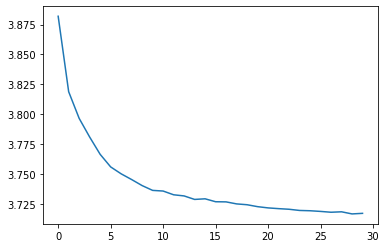

In [22]:
plt.plot(all_losses_embed)

In [23]:
torch.save(rnn_embedding.state_dict(), "./models/lstm_embedding_model_256hdim.pt")


In [24]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn_embedding, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=3.05)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

ver so the the state the the star that
in the the star the stan the star that the
earth the star the star that the star the sterles
unthree the stant the star that the star

of the seen the stan the tear the star the
be the the star the stan the star that the seen
be the the star that the star that the
goore the sort the the star that the star that

euther that the star the star that the star
loon another that the stans
lool the star the ster that the
poor the soul state the that the star that the

kin that the stan the stan the state the stare
know stans anstate the star


In [31]:
start_sample = sampleMultipleStart(rnn_embedding, start_seq="shall i compare thee to a summer's day", 
                             length=1000, temperature=1.5)

start_sample


"shall i compare thee to a summer's day the stant the star that the star that the star that the star that the star that the star that the star that the star that the star that the star that the star that the star that the star that the star that the star the steal the star that the star the steal the stane the star that the star that the star the stan the star that the star that the star that the star that the star that the star the steal the that the star that the star the steal the star that the star that the star that the star that the star the star the stan the star that the star the steal the stant the star that the star that the star the steal the star that the star that the star that the star that the star the steal the star the star the ster that the star that the star that the star the stan the steal the star the stant the star that the star that the star that the star that the star the steal the star that the star the steal the star that the star that the star the steal the s

In [32]:
for line in range(14):
    print(' '.join(start_sample.split(" ")[line * 14:line * 14 + 10]))

shall i compare thee to a summer's day the stant
star that the star that the star that the star
the star that the star that the star that the
that the star that the star that the star that
the star that the star the steal the stane the
that the star the stan the star that the star
the star that the star that the star the steal
that the star the steal the star that the star
the star that the star the star the stan the
the steal the stant the star that the star that
the star that the star that the star that the
the steal the star the star the ster that the
that the star the stan the steal the star the
the star that the star that the star that the


In [ ]:
# Load model
# Model class must be defined somewhere
rnn_load_model = RNN_Embedding(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size)
rnn_load_model.load_state_dict(torch.load("./models/lstm_embedding_model.pt"))
rnn_load_model.eval()